In [1]:
%load_ext autotime
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')
import time
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score,auc,recall_score,precision_score,precision_recall_curve,confusion_matrix,\
classification_report,roc_auc_score,f1_score

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

time: 1.01 s (started: 2024-02-22 14:11:10 +05:30)


In [2]:
master_data = pd.read_pickle('master_data.pkl')

time: 13 ms (started: 2024-02-22 14:11:11 +05:30)


In [3]:
master_data = master_data[~master_data.loan_status.isin(['Closed', 'Foreclosed'])]

time: 4.84 ms (started: 2024-02-22 14:11:11 +05:30)


In [4]:
master_data['event'].value_counts(dropna=False)

event
0.0    3309
1.0    1966
Name: count, dtype: int64

time: 5.36 ms (started: 2024-02-22 14:11:11 +05:30)


In [5]:
master_data.head()

,niro_opportunity_id,month_clearance_status,month_presentation_bucket,prev_month_tat,prev_month_tat_bkt,month_pos,presentation_lag,tenor_in_months,tenor_rank,disbursed_amount,months_since_disb,pf,monthly_income_(net_take_home),monthly_emi,income_rank,state,tier,loan_status,foir,ok/problem_areas,repeat_cases,mobile_no,event,advance_collection_code_month,category,principal_amount,interest_rate,supply,propensity,offer_type,max_amount,income_source,purpose_of_loan,residence_ownership_type,marital_status,cpv_type,demand,bureau_gender,bureau_pincode,calculated_age,bureau_state,native_language,current_salary,available_income,foir_dlq,foir_cibil,foir_trd,foir_mean,new_foir,naps_disb_score,rnk,max_aggregate_bankcard_utilisation_l12m,cc_util_revolving_l1m,bank_card_payment_category,no_of_60p_accs_ever,no_of_deduped_inquiries,total_cl_open_mortgage_trades_l12m,total_balance_open_mortgage_trades_l12m,total_bal_of_open_pl_l12m,months_since_oldest_trade,no_of_mortgage_trades,no_of_open_cc_trades,no_of_business_general_trades,no_of_30p_accs_ever,no_of_trades,total_bal_open_trades_l12m,total_bal_open_auto_trades_l12m,months_since_recent_chargedoff180p,total_cl_open_auto_trades_l12m,total_cl_open_pl_trades_l12m,no_of_chargedoff180p,total_cl_of_cc_trades_l12m,no_of_90p_accs_ever,total_bal_of_chargedoff_trades,worst_rating_l12m,current_utilization_of_top_wallet_bankcard,no_of_trades_pl_2w_gl_cd,total_bal_open_trades_l12m_except_wo_cc_od,no_of_deduped_inquiries_l12m,no_of_deduped_inquiries_l6m,no_of_deduped_inquiries_l3m,no_of_deduped_inquiries_l1m,worst_rating_l24m,worst_rating_l6m,worst_rating_l3m,worst_rating_l1m,no_of_60p_accs_l24m,no_of_60p_accs_l12m,no_of_trades_bounced_l36m,no_of_trades_bounced_l12m,no_of_cc_trades_60p_l24m,no_of_30p_cc_l24m,no_of_cc_trades_60p_l12m,no_of_30p_cc_l12m,no_of_cc_lt30p_l12m,no_cc_sanctionedamt_lt30k_l36m,no_pl_sanctionedamt_lt30k_l36m,no_tr_opened_l6m,worst_dpd_l36m,total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades,no_tr_opened_l12m,no_tr_opened_l3m,per_of_30p_accs_ever,total_payment_amount_bankcard_accs_l3m,max_revolving_monthly_spend_l12m,total_monthly_obligations_l3m,total_balance_bankcard_accs_l3m,no_of_trades_unsec,total_payment_amount_l3m,worst_dpd_l2m,secured_accounts_count,unsecured_accounts_count,secured_high_credit_sum,unsecured_high_credit_sum,secured_amount_overdue_sum,unsecured_amount_overdue_sum,secured_balances_sum,unsecured_balances_sum,own_accounts_count,other_accounts_count,cibil_score,no_of_open_cc_trades_bkt,years_on_bureau_bkt,no_of_deduped_inquiries_bkt,secured_loan_bkt,cust_category,cust_hirisk,cc_inactive,cc_nobc,cc_revolver,cc_rvlrplus,cc_transactor,cc_tranplus,credithungry,naps_new,naps_new_bkt,region,pos_by_la,offered_la_by_disb_la,emi_by_income,naps_diff,naps_diff_per,mob_by_tenure,interest_rate_bkt
0,8cf95828-6981-4f75-a766-f79769c8bd8a,B) Bounce,E) Bkt 3+,999.0,F) Unpaid,90887.788379,No,18,3,180001,24,0.034993,30000,12295,3,TAMIL NADU,Tier 1,NPA,0.42,Problem Area,1.0,9952744141,1.0,NaN,CAT-C,187754,22,quikr,None,PRE_APPROVED,180000,Self Employed,Others,None,SINGLE,None,liquiloans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.54,99.31,RVLRPLUS,13,69,2737484.0,2363297.0,385903.0,206,2,5,0,14,39,3611695.0,-1.0,6,-1.0,732754.0,13,1210145.0,13,664885.0,9.0,123,22,2749200.0,0,0,0,0,9.0,9.0,9.0,0.0,13,13,39,39,7,17,7,10,12,1,0,0,9.0,2946810.0,0,0,36,41292.0,319656.0,94460.20,1040704.0,22,166578.0,9.0,2,12,2737484.0,2729813.0,26298.0,1124038.0,2363297.0,1426607.0,0,16,652,3+,4+ Yrs,<=1,Secured Loan 7.5L+,Carded 50K+ With Secured Loans,0,0,0,0,1,0,0,0,812,791-818,South,0.504929,0.999994,0.409833,NaN,NaN,1.333333,C) 21-24
1,cdf9f121-0176-4ca9-aa9d-f5d4048af74b,B) Bounce,A) Bkt 0,1.0,C) 1-10,12461.921883,No,24,4,125003,23,0.034981,80000,6353,5,ANDHRA PRADESH,Tier 1,Active,0.47,OK Area,1.0,9989185412,0.0,CTB,CAT-C,130385,16,quikr,Medium,PRE_APPROVED,150000,Self Employed,Others,None,MARRIED,None,liquiloans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0

time: 34.4 ms (started: 2024-02-22 14:11:11 +05:30)


In [6]:
StaticVars = ['niro_opportunity_id', 'event']

time: 264 µs (started: 2024-02-22 14:11:12 +05:30)


##### Bkt 0 cases

In [7]:
master_data = master_data[master_data.month_presentation_bucket.isin(['A) Bkt 0'])].reset_index(drop=True)

time: 10.6 ms (started: 2024-02-22 14:11:14 +05:30)


#### Variable selections

In [8]:
green_vars = ["advance_collection_code_month",
"bank_card_payment_category",
"bureau_gender",
"calculated_age",
"category",
"cc_inactive",
"cc_nobc",
"cc_revolver",
"cc_rvlrplus",
"cc_tranplus",
"cc_transactor",
"cibil_score",
"cpv_type",
"current_utilization_of_top_wallet_bankcard",
"cust_category",
"foir_cibil",
"foir_dlq",
"foir_mean",
"foir_trd",
"income_rank",
"income_source",
"loan_status",
"marital_status",
"max_aggregate_bankcard_utilisation_l12m",
"mob_by_tenure",
"month_clearance_status",
"month_pos",
"month_presentation_bucket",
"monthly_income_(net_take_home)",
"months_since_disb",
"months_since_oldest_trade",
"months_since_recent_chargedoff180p",
"naps_disb_score",
"new_foir",
"no_cc_sanctionedamt_lt30k_l36m",
"no_of_30p_accs_ever",
"no_of_60p_accs_ever",
"no_of_60p_accs_l12m",
"no_of_60p_accs_l24m",
"no_of_90p_accs_ever",
"no_of_cc_trades_60p_l12m",
"no_of_cc_trades_60p_l24m",
"no_of_chargedoff180p",
"no_of_deduped_inquiries",
"no_of_deduped_inquiries_l12m",
"no_of_deduped_inquiries_l1m",
"no_of_deduped_inquiries_l3m",
"no_of_deduped_inquiries_l6m",
"no_of_mortgage_trades",
"no_of_open_cc_trades_bkt",
"no_tr_opened_l12m",
"no_tr_opened_l3m",
"ok/problem_areas",
"per_of_30p_accs_ever",
"pos_by_la",
"prev_month_tat",
"propensity",
"region",
"secured_accounts_count",
"secured_amount_overdue_sum",
"secured_balances_sum",
"secured_loan_bkt",
"tenor_in_months",
"tenor_rank",
"total_bal_of_chargedoff_trades",
"total_bal_open_trades_l12m_except_wo_cc_od",
"total_balance_open_mortgage_trades_l12m",
"total_cl_open_auto_trades_l12m",
"total_cl_open_mortgage_trades_l12m",
"total_cl_open_pl_trades_l12m",
"total_payment_amount_bankcard_accs_l3m",
"total_payment_amount_l3m",
"unsecured_amount_overdue_sum",
"worst_dpd_l36m",
"worst_rating_l12m",
"worst_rating_l24m",
"worst_rating_l3m",
"worst_rating_l6m",
"years_on_bureau_bkt",
"naps_diff_per"]

time: 1.14 ms (started: 2024-02-22 14:11:15 +05:30)


In [9]:
yellow_vars = ["disbursed_amount",
"foir",
"interest_rate",
"max_amount",
"max_revolving_monthly_spend_l12m",
"naps_new",
"no_of_30p_cc_l12m",
"no_of_30p_cc_l24m",
"no_of_open_cc_trades",
"no_pl_sanctionedamt_lt30k_l36m",
"prev_month_tat_bkt",
"principal_amount",
"tier",
"unsecured_balances_sum",
"unsecured_high_credit_sum",
# "cc_util_revolving_l1m",
"worst_dpd_l2m"]

time: 539 µs (started: 2024-02-22 14:11:15 +05:30)


In [10]:
# yellow_vars = []

time: 182 µs (started: 2024-02-22 14:11:16 +05:30)


In [11]:
master_data = master_data[StaticVars + green_vars + yellow_vars]

time: 3.73 ms (started: 2024-02-22 14:11:16 +05:30)


In [12]:
master_data.shape

(3278, 98)

time: 3.8 ms (started: 2024-02-22 14:11:17 +05:30)


##### Dropping columns

In [13]:
#Columns with all nulls or single value(all 0's)
one_val_cols = [col for col in master_data.columns if len(master_data[col].value_counts().index) <= 1]
#Columns with more than 90% data as null
null_val_cols = [col for col in master_data.columns if sum(master_data[col].isna())/len(master_data) >= 0.90]
master_data.drop(columns = list(set(one_val_cols + null_val_cols)), inplace=True)

time: 50.8 ms (started: 2024-02-22 14:11:20 +05:30)


In [14]:
master_data = master_data[master_data['event'].notna()].copy().reset_index(drop=True)

time: 3.75 ms (started: 2024-02-22 14:11:20 +05:30)


##### Column operations

In [15]:
master_data.head()

,niro_opportunity_id,event,advance_collection_code_month,bank_card_payment_category,bureau_gender,calculated_age,category,cc_inactive,cc_nobc,cc_revolver,cc_rvlrplus,cc_tranplus,cc_transactor,cibil_score,cpv_type,current_utilization_of_top_wallet_bankcard,cust_category,foir_cibil,foir_dlq,foir_mean,foir_trd,income_rank,income_source,marital_status,max_aggregate_bankcard_utilisation_l12m,mob_by_tenure,month_clearance_status,month_pos,monthly_income_(net_take_home),months_since_disb,months_since_oldest_trade,months_since_recent_chargedoff180p,naps_disb_score,new_foir,no_cc_sanctionedamt_lt30k_l36m,no_of_30p_accs_ever,no_of_60p_accs_ever,no_of_60p_accs_l12m,no_of_60p_accs_l24m,no_of_90p_accs_ever,no_of_cc_trades_60p_l12m,no_of_cc_trades_60p_l24m,no_of_chargedoff180p,no_of_deduped_inquiries,no_of_deduped_inquiries_l12m,no_of_deduped_inquiries_l1m,no_of_deduped_inquiries_l3m,no_of_deduped_inquiries_l6m,no_of_mortgage_trades,no_of_open_cc_trades_bkt,no_tr_opened_l12m,no_tr_opened_l3m,ok/problem_areas,per_of_30p_accs_ever,pos_by_la,prev_month_tat,propensity,region,secured_accounts_count,secured_amount_overdue_sum,secured_balances_sum,secured_loan_bkt,tenor_in_months,tenor_rank,total_bal_of_chargedoff_trades,total_bal_open_trades_l12m_except_wo_cc_od,total_balance_open_mortgage_trades_l12m,total_cl_open_auto_trades_l12m,total_cl_open_mortgage_trades_l12m,total_cl_open_pl_trades_l12m,total_payment_amount_bankcard_accs_l3m,total_payment_amount_l3m,unsecured_amount_overdue_sum,worst_dpd_l36m,worst_rating_l12m,worst_rating_l24m,worst_rating_l3m,worst_rating_l6m,years_on_bureau_bkt,naps_diff_per,disbursed_amount,foir,interest_rate,max_amount,max_revolving_monthly_spend_l12m,naps_new,no_of_30p_cc_l12m,no_of_30p_cc_l24m,no_of_open_cc_trades,no_pl_sanctionedamt_lt30k_l36m,prev_month_tat_bkt,principal_amount,tier,unsecured_balances_sum,unsecured_high_credit_sum,worst_dpd_l2m
0,cdf9f121-0176-4ca9-aa9d-f5d4048af74b,0.0,CTB,NOBC,NaN,NaN,CAT-C,0,1,0,0,0,0,785,None,-2,None,NaN,NaN,NaN,NaN,5,Self Employed,MARRIED,-2.00,0.958333,B) Bounce,12461.921883,80000,23,111,-1,NaN,NaN,0,0,0,0,0,0,0,0,0,24,1,0,0,0,0,No Credit Cards,0,0,OK Area,0,0.099693,1.0,Medium,South,1,0.0,56723.0,Secured Loan < 2L,24,4,-1.0,196247.0,-1.0,-1.0,-1.0,-1.0,-7.0,-2.0,0.0,1.0,1.0,1.0,1.0,1.0,4+ Yrs,NaN,125003,0.47,16,150000,-2.0,698,-2,-2,0,-1,C) 1-10,130385,Tier 1,0.0,0.0,0.0
1,72f68e32-3132-45e1-8953-aae1a65d9086,0.0,CTB,RVLRPLUS,NaN,NaN,CAT-AB,0,0,0,1,0,0,775,None,101,Carded 50K+,NaN,NaN,NaN,NaN,3,Salaried,MARRIED,85.41,0.916667,B) Bounce,24939.103005,38000,22,174,-1,NaN,NaN,0,0,0,0,0,0,0,0,0,49,20,2,4,17,0,1-2,9,1,OK Area,0,0.191838,1.0,Medium,South,0,0.0,0.0,No Secured loan,24,4,-1.0,208314.0,-1.0,-1.0,-1.0,658971.0,38390.0,166548.0,0.0,1.0,1.0,1.0,1.0,1.0,4+ Yrs,NaN,130001,0.42,15,210000,69293.0,722,0,0,2,14,C) 1-10,133142,Tier 1,426159.0,1266630.0,1.0
2,466c7cdf-fc5f-4a29-b722-dc7b56d4e8cb,1.0,CTB,RVLRPLUS,NaN,NaN,CAT-AB,0,0,0,1,0,0,731,None,71,Carded 50K+ With Secured Loans,NaN,NaN,NaN,NaN,4,Salaried,MARRIED,87.16,0.916667,B) Bounce,50063.580501,70000,22,190,-1,NaN,NaN,0,3,1,1,1,1,0,0,0,20,1,0,0,0,3,3+,2,0,OK Area,13,0.238396,20.0,High,South,3,0.0,1588365.0,Secured Loan 7.5L+,24,4,-1.0,1750098.0,1588365.0,-1.0,2175000.0,717076.0,63223.0,254371.0,18052.0,4.0,4.0,4.0,1.5,4.0,4+ Yrs,NaN,210002,0.43,15,210000,195601.0,712,2,2,3,0,D) 10 - 20,215076,Tier 3,410524.0,2041282.0,1.5
3,36b33903-2cdf-465a-8156-f98fbbddcd62,0.0,NTB,REVOLVER,NaN,NaN,CAT-AB,0,0,1,0,0,0,711,None,101,Carded 50K+,NaN,NaN,NaN,NaN,6,Salaried,None,95.31,0.875000,B) Bounce,38725.296427,115000,21,196,18,NaN,NaN,0,2,2,0,2,2,0,0,1,61,12,1,2,8,0,1-2,4,0,OK Area,9,0.193626,0.0,High,South,1,0.0,2108347.0,Secured Loan 7.5L+,24,4,0.0,3414891.0,-1.0,-1.0,-1.0,1879510.0,4116.0,206885.0,0.0,9.0,1.5,9.0,1.0,1.5,4+ Yrs,NaN,200000,0.44,17,200000,500000.0,633,0,0,2,1,B) 0,203604,Tier 3,1941252.0,4781816.0,1.0
4,bb506b8f-8fc7-457b-9aa2-4a7e9272f93c,0.0,CTB,NOBC,NaN,NaN,CAT-AB,0,1,0,0,0,0,764,None,-1,Unsecured Loan 50K+,NaN,N

time: 31.5 ms (started: 2024-02-22 14:11:21 +05:30)


In [16]:
VarsToDrop = ['demand', 'supply', 'bureau_pincode', 'city', 'mobile_no', 'state', 'bureau_state', 'native_language']
master_data = master_data[master_data.columns[~master_data.columns.isin(VarsToDrop)]]

time: 2.04 ms (started: 2024-02-22 14:11:21 +05:30)


In [17]:
for col in master_data.columns:
    if not pd.api.types.is_numeric_dtype(master_data[col]): 
        try:
            master_data[col] = master_data[col].astype(float)
        except:
            print(col)

niro_opportunity_id
advance_collection_code_month
bank_card_payment_category
bureau_gender
category
cpv_type
cust_category
income_source
marital_status
month_clearance_status
no_of_open_cc_trades_bkt
ok/problem_areas
propensity
region
secured_loan_bkt
years_on_bureau_bkt
prev_month_tat_bkt
tier
time: 3.77 ms (started: 2024-02-22 14:11:22 +05:30)


#### Z-score normalization for numerical fields

In [18]:
master_data.replace(np.inf, 9999999999, inplace=True)

time: 5.87 ms (started: 2024-02-22 14:11:22 +05:30)


In [19]:
numerical_cols = []
for col in master_data.columns:
    if (not pd.api.types.is_object_dtype(master_data[col])) and (col not in StaticVars) and (len(np.unique(master_data[col]))>5):
        numerical_cols.append(col)

time: 14.5 ms (started: 2024-02-22 14:11:23 +05:30)


In [20]:
from sklearn.preprocessing import StandardScaler
# Perform Z-score normalization on numerical variables
scaler = StandardScaler()
numerical_data_normalized = scaler.fit_transform(master_data.loc[:,numerical_cols])
master_data.loc[:,numerical_cols] = numerical_data_normalized

time: 15.1 ms (started: 2024-02-22 14:11:23 +05:30)


#### Create train test validation split

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
master_data = master_data.sample(frac=1).reset_index(drop=True)
# Split the data into training, validation and testing sets using stratified shuffle split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_val_idx, test_idx = next(sss.split(master_data, master_data[['event']]))  #, 'month_presentation_bucket'
train_val = master_data.iloc[train_val_idx].reset_index(drop=True)
test = master_data.iloc[test_idx].reset_index(drop=True)

# Print the shape of the resulting data
print('Training data shape:', train_val.shape)
print('Train Event % = ', str(train_val.event.mean()))
print('Test data shape:', test.shape)
print('Test Event % = ', str(test.event.mean()))

Training data shape: (2294, 96)
Train Event % =  0.0919790758500436
Test data shape: (984, 96)
Test Event % =  0.09146341463414634
time: 25.4 ms (started: 2024-02-22 14:11:24 +05:30)


In [22]:
train_val_copy = train_val.copy()
test_copy = test.copy()

time: 4.07 ms (started: 2024-02-22 14:11:24 +05:30)


#### Converting categorical field to one hot encoding

##### Also fill null values in categorical field with "Other"

In [23]:
for col in set(train_val.columns):
    if pd.api.types.is_object_dtype(train_val[col]) and (col not in StaticVars):
        print("One hot encoding ", col)

        one_hot = pd.get_dummies(train_val[col], prefix="dummy_"+col, dummy_na=False)
        train_val = pd.concat([train_val, one_hot.iloc[:,:-1]], axis=1)
        train_val.drop(col, axis=1, inplace=True)

        one_hot = pd.get_dummies(test[col], prefix="dummy_"+col, dummy_na=False)
        test = pd.concat([test, one_hot], axis=1)
        test.drop(col, axis=1, inplace=True)

One hot encoding  income_source
One hot encoding  years_on_bureau_bkt
One hot encoding  category
One hot encoding  month_clearance_status
One hot encoding  cpv_type
One hot encoding  bank_card_payment_category
One hot encoding  no_of_open_cc_trades_bkt
One hot encoding  tier
One hot encoding  bureau_gender
One hot encoding  ok/problem_areas
One hot encoding  propensity
One hot encoding  marital_status
One hot encoding  region
One hot encoding  prev_month_tat_bkt
One hot encoding  advance_collection_code_month
One hot encoding  secured_loan_bkt
One hot encoding  cust_category
time: 47.5 ms (started: 2024-02-22 14:11:25 +05:30)


In [24]:
train_val = train_val[list(set(test.columns) & set(train_val.columns))]
test = test[list(set(test.columns) & set(train_val.columns))]

time: 4.79 ms (started: 2024-02-22 14:11:26 +05:30)


In [25]:
train_val.shape, test.shape

((2294, 121), (984, 121))

time: 2.67 ms (started: 2024-02-22 14:11:26 +05:30)


#### Binning

In [26]:
from optbinning import BinningProcess

(CVXPY) Feb 22 02:11:27 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 22 02:11:27 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
time: 550 ms (started: 2024-02-22 14:11:27 +05:30)


In [27]:
df_train = train_val.copy()
df_test = test.copy()
cat_cols = [col for col in df_train.columns if (((df_train[col].dtype.kind not in 'bifc') or (len(np.unique(df_train[col]))<=2)) and (not (col in StaticVars)))]
# cat_cols = [col for col in df_train.columns if ((len(np.unique(df_train[col]))<=2) and (not (col in StaticVars)))]

time: 12.1 ms (started: 2024-02-22 14:11:27 +05:30)


In [28]:
binning_fit_params = {
    "available_income": {"monotonic_trend": "descending"},
    "cibil_score": {"monotonic_trend": "descending"},
}

time: 235 µs (started: 2024-02-22 14:11:28 +05:30)


In [29]:
foir_cols = [x for x in master_data.columns if ('foir' in x) and ('new' not in x)]
# days_balance_less_than_cols = [x for x in master_data.columns if (('days_balance_less_than' in x) and ('bkt' not in x))]
# no_enq_cols = [x for x in master_data.columns if (('no_enq' in x) and ('bkt' not in x))]
# delq_cols = [x for x in master_data.columns if ((('is_' in x) or ('noof_times' in x) or ('pct_' in x)) and ('bkt' not in x))]

time: 662 µs (started: 2024-02-22 14:11:28 +05:30)


In [30]:
for col in foir_cols:
    binning_fit_params[col] = {"monotonic_trend": "ascending"}

# for col in days_balance_less_than_cols:
#     binning_fit_params[col] = {"monotonic_trend": "ascending"}

# for col in no_enq_cols + delq_cols:
#     binning_fit_params[col] = {"monotonic_trend": "ascending"}

time: 444 µs (started: 2024-02-22 14:11:28 +05:30)


In [31]:
feature_list = df_train.drop(columns=StaticVars).columns.values
binning_process = BinningProcess(categorical_variables=cat_cols, variable_names=feature_list, min_prebin_size = 0.01, max_n_bins=5, min_bin_size = 0.03, special_codes=[9999999999, np.nan], max_pvalue = 0.35, max_pvalue_policy = "consecutive", selection_criteria = { "iv": {"min": 0.02, "strategy": "highest"}, "quality_score": {"min": 0.02}}) # binning_fit_params = binning_fit_params,
binning_process.fit(df_train.drop(columns=StaticVars), df_train['event'])
df_train_binned = binning_process.transform(df_train.drop(columns=StaticVars), metric="bins")
df_test_binned = binning_process.transform(df_test.drop(columns=StaticVars), metric="bins")

df_train_binned_woe = binning_process.transform(df_train.drop(columns=StaticVars), metric="woe")
df_test_binned_woe = binning_process.transform(df_test.drop(columns=StaticVars), metric="woe")

BinningProcess(categorical_variables=['dummy_tier_Tier 1',
                                      'dummy_advance_collection_code_month_NTB-6N',
                                      'dummy_cust_category_Carded 50K+ With '
                                      'Secured Loans',
                                      'cc_revolver',
                                      'dummy_no_of_open_cc_trades_bkt_3+',
                                      'dummy_cpv_type_PHYSICAL',
                                      'dummy_secured_loan_bkt_Secured Loan < '
                                      '2L',
                                      'dummy_bureau_gender_Female',
                                      'dummy_region_North',
                                      'dummy_region_Central',
                                      'dummy...
       'no_of_open_cc_trades', 'no_of_30p_cc_l24m',
       'total_payment_amount_l3m', 'dummy_income_source_Salaried',
       'worst_rating_l6m', 'unsecured_high_credit_sum',
       'no_of_chargedoff180p', 'dummy_prev_month_tat_bkt_A) < 0',
       'dummy_advance_collection_code_month_NTB',
       'dummy_bank_card_payment_category_NOBC', 'dummy_region_East',
       'unsecured_amount_overdue_sum'], dtype=object))

time: 6.31 s (started: 2024-02-22 14:11:29 +05:30)


In [32]:
binning_process.information(print_level=2)

optbinning (Version 0.19.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    max_n_prebins                         20   * d
    min_prebin_size                     0.01   * U
    min_n_bins                            no   * d
    max_n_bins                             5   * U
    min_bin_size                        0.03   * U
    max_bin_size                          no   * d
    max_pvalue                          0.35   * U
    max_pvalue_policy            consecutive   * d
    selection_criteria                   yes   * U
    fixed_variables                       no   * d
    categorical_variables                yes   * U
    special_codes                        yes   * U
    split_digits                          no   * d
    binning_fit_params                    no   * d
    binning_transform_params              no   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                   22

In [33]:
df_train_binned.shape

(2294, 79)

time: 1.22 ms (started: 2024-02-22 14:11:35 +05:30)


In [34]:
feature_list_binned = [(str(x) + '_binned_opt') for x in df_train_binned.columns.values]
feature_list_binned_woe = [(str(x) + '_binned_opt_woe') for x in df_train_binned.columns.values]

time: 297 µs (started: 2024-02-22 14:11:35 +05:30)


In [35]:
train_val = train_val[StaticVars + list(df_train_binned.columns)]
train_val[feature_list_binned] = df_train_binned
train_val[feature_list_binned_woe]= df_train_binned_woe
test = test[StaticVars + list(df_test_binned.columns)]
test[feature_list_binned] = df_test_binned
test[feature_list_binned_woe] = df_test_binned_woe

time: 38.7 ms (started: 2024-02-22 14:11:35 +05:30)


In [36]:
train_val.head()

,niro_opportunity_id,event,principal_amount,max_aggregate_bankcard_utilisation_l12m,no_of_60p_accs_l24m,no_of_cc_trades_60p_l24m,foir_trd,foir_mean,total_cl_open_auto_trades_l12m,no_cc_sanctionedamt_lt30k_l36m,total_cl_open_pl_trades_l12m,total_payment_amount_bankcard_accs_l3m,no_of_30p_accs_ever,total_bal_open_trades_l12m_except_wo_cc_od,naps_new,worst_dpd_l2m,worst_rating_l24m,worst_rating_l12m,prev_month_tat,dummy_prev_month_tat_bkt_B) 0,pos_by_la,no_pl_sanctionedamt_lt30k_l36m,worst_rating_l3m,disbursed_amount,income_rank,tenor_rank,per_of_30p_accs_ever,months_since_oldest_trade,total_balance_open_mortgage_trades_l12m,secured_accounts_count,no_of_deduped_inquiries_l6m,no_of_deduped_inquiries,interest_rate,no_of_deduped_inquiries_l1m,monthly_income_(net_take_home),cc_transactor,no_of_cc_trades_60p_l12m,no_of_90p_accs_ever,max_amount,dummy_advance_collection_code_month_CMU-DPD,new_foir,current_utilization_of_top_wallet_bankcard,dummy_secured_loan_bkt_No Secured loan,naps_diff_per,unsecured_balances_sum,foir,naps_disb_score,dummy_advance_collection_code_month_CTB,cibil_score,dummy_prev_month_tat_bkt_C) 1-10,no_of_deduped_inquiries_l3m,max_revolving_monthly_spend_l12m,dummy_category_CAT-AB,calculated_age,month_pos,dummy_no_of_open_cc_trades_bkt_1-2,no_of_mortgage_trades,total_cl_open_mortgage_trades_l12m,no_of_60p_accs_l12m,dummy_propensity_High,mob_by_tenure,no_of_deduped_inquiries_l12m,no_tr_opened_l12m,no_of_60p_accs_ever,secured_balances_sum,tenor_in_months,cc_nobc,dummy_ok/problem_areas_OK Area,no_of_30p_cc_l12m,worst_dpd_l36m,dummy_prev_month_tat_bkt_E) 21 - 29,dummy_secured_loan_bkt_Secured Loan 7.5L+,months_since_disb,no_of_open_cc_trades,no_of_30p_cc_l24m,total_payment_amount_l3m,worst_rating_l6m,unsecured_high_credit_sum,dummy_advance_collection_code_month_NTB,dummy_bank_card_payment_category_NOBC,unsecured_amount_overdue_sum,principal_amount_binned_opt,max_aggregate_bankcard_utilisation_l12m_binned_opt,no_of_60p_accs_l24m_binned_opt,no_of_cc_trades_60p_l24m_binned_opt,foir_trd_binned_opt,foir_mean_binned_opt,total_cl_open_auto_trades_l12m_binned_opt,no_cc_sanctionedamt_lt30k_l36m_binned_opt,total_cl_open_pl_trades_l12m_binned_opt,total_payment_amount_bankcard_accs_l3m_binned_opt,no_of_30p_accs_ever_binned_opt,total_bal_open_trades_l12m_except_wo_cc_od_binned_opt,naps_new_binned_opt,worst_dpd_l2m_binned_opt,worst_rating_l24m_binned_opt,worst_rating_l12m_binned_opt,prev_month_tat_binned_opt,dummy_prev_month_tat_bkt_B) 0_binned_opt,pos_by_la_binned_opt,no_pl_sanctionedamt_lt30k_l36m_binned_opt,worst_rating_l3m_binned_opt,disbursed_amount_binned_opt,income_rank_binned_opt,tenor_rank_binned_opt,per_of_30p_accs_ever_binned_opt,months_since_oldest_trade_binned_opt,total_balance_open_mortgage_trades_l12m_binned_opt,secured_accounts_count_binned_opt,no_of_deduped_inquiries_l6m_binned_opt,no_of_deduped_inquiries_binned_opt,interest_rate_binned_opt,no_of_deduped_inquiries_l1m_binned_opt,monthly_income_(net_take_home)_binned_opt,cc_transactor_binned_opt,no_of_cc_trades_60p_l12m_binned_opt,no_of_90p_accs_ever_binned_opt,max_amount_binned_opt,dummy_advance_collection_code_month_CMU-DPD_binned_opt,new_foir_binned_opt,current_utilization_of_top_wallet_bankcard_binned_opt,dummy_secured_loan_bkt_No Secured loan_binned_opt,naps_diff_per_binned_opt,unsecured_balances_sum_binned_opt,foir_binned_opt,naps_disb_score_binned_opt,dummy_advance_collection_code_month_CTB_binned_opt,cibil_score_binned_opt,dummy_prev_month_tat_bkt_C) 1-10_binned_opt,no_of_deduped_inquiries_l3m_binned_opt,max_revolving_monthly_spend_l12m_binned_opt,dummy_category_CAT-AB_binned_opt,calculated_age_binned_opt,month_pos_binned_opt,dummy_no_of_open_cc_trades_bkt_1-2_binned_opt,no_of_mortgage_trades_binned_opt,total_cl_open_mortgage_trades_l12m_binned_opt,no_of_60p_accs_l12m_binned_opt,dummy_propensity_High_binned_opt,mob_by_tenure_binned_opt,no_of_deduped_inquiries_l12m_binned_opt,no_tr_opened_l12m_binned_opt,no_of_60p_accs_ever_binned_opt,secured_balances_sum_binned_

time: 66 ms (started: 2024-02-22 14:11:35 +05:30)


In [37]:
train_val.shape, test.shape

((2294, 239), (984, 239))

time: 2.11 ms (started: 2024-02-22 14:11:35 +05:30)


In [38]:
train_val.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2294 entries, 0 to 2293
Data columns (total 239 columns):
 #    Column                                                      Non-Null Count  Dtype  
---   ------                                                      --------------  -----  
 0    niro_opportunity_id                                         2294 non-null   object 
 1    event                                                       2294 non-null   float64
 2    principal_amount                                            2294 non-null   float64
 3    max_aggregate_bankcard_utilisation_l12m                     2294 non-null   float64
 4    no_of_60p_accs_l24m                                         2294 non-null   float64
 5    no_of_cc_trades_60p_l24m                                    2294 non-null   float64
 6    foir_trd                                                    2238 non-null   float64
 7    foir_mean                                                   2238 non-null   

In [39]:
summary = binning_process.summary()
summary.head()

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,dummy_tier_Tier 1,categorical,OPTIMAL,False,2,0.012819,0.001601,0.052112,0.027434
1,secured_amount_overdue_sum,numerical,OPTIMAL,False,2,0.016095,0.001984,0.025667,0.005514
2,dummy_advance_collection_code_month_NTB-6N,categorical,OPTIMAL,False,2,0.004763,0.000595,0.025153,0.004488
3,principal_amount,numerical,OPTIMAL,True,4,0.131713,0.015995,0.175324,0.284994
4,max_aggregate_bankcard_utilisation_l12m,numerical,OPTIMAL,True,5,0.146104,0.01753,0.179453,0.411059


time: 7.47 ms (started: 2024-02-22 14:11:35 +05:30)


In [40]:
# summary.to_csv('variable_binned_summary.csv', index = False)

time: 108 µs (started: 2024-02-22 14:11:35 +05:30)


In [41]:
summary[summary['status'] == 'INFEASIBLE']

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score


time: 3.08 ms (started: 2024-02-22 14:11:35 +05:30)


#### Distribution Data Prep

In [42]:
# t1 = train_val[['event'] + feature_list_binned + cat_cols]

time: 109 µs (started: 2024-02-22 14:11:35 +05:30)


In [ ]:
# var_summary = pd.DataFrame()
# for col in t1.columns[1:]:
#     t2 = pd.merge(t1.groupby([col])['event'].count().rename('count'), t1.groupby([col])['event'].sum().astype(int).rename('events'), on = col).reset_index().rename(columns = {col:'buckets'})
#     t2['var_name'] = col
#     t2['non_events'] = t2['count'] - t2['events']
#     t2['event_rate'] = t2['events']/t2['count']
#     t2['non_event_rate'] = t2['non_events']/t2['count']
#     t2['event_prop'] = t2['events'] / sum(t2['events'])
#     t2['non_event_prop'] = t2['non_events'] / sum(t2['non_events'])
#     t2['woe'] = np.log(t2['event_prop'] / t2['non_event_prop'])
#     t2['iv'] = (t2['event_prop'] - t2['non_event_prop']) * t2['woe']
#     var_summary = pd.concat([var_summary, t2])

In [ ]:
# var_summary.to_csv('variable_summary.csv')

#### Removing raw variables with |correlation| >= 0.9

In [43]:
# calculate correlation matrix
corr_matrix = train_val[[x for x in train_val.columns if (('_binned_opt' not in x) and (x not in StaticVars))]].corr()

# find pairs of variables with correlation 1 or -1
correlated_vars = []
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if col != row and abs(corr_matrix.loc[row, col]) >= 0.9:
            correlated_vars.append((row, col))

# sort pairs by iv value and drop one variable from each pair
for var1, var2 in correlated_vars:
    if (var1 in summary.name.values) and (var2 in summary.name.values) and (var1 in train_val.columns.values) and (var2 in train_val.columns.values):
        if summary.loc[summary.name == var1, 'iv'].values[0] > summary.loc[summary.name == var2, 'iv'].values[0]:
            print(var1,var2)
            train_val.drop(var2, axis=1, inplace=True)
            test.drop(var2, axis=1, inplace=True)
        else:
            print(var1,var2)
            train_val.drop(var1, axis=1, inplace=True)
            test.drop(var1, axis=1, inplace=True)

disbursed_amount principal_amount
month_pos principal_amount
no_of_60p_accs_l12m no_of_60p_accs_l24m
no_of_cc_trades_60p_l12m no_of_cc_trades_60p_l24m
cc_nobc no_cc_sanctionedamt_lt30k_l36m
dummy_bank_card_payment_category_NOBC no_cc_sanctionedamt_lt30k_l36m
secured_balances_sum total_bal_open_trades_l12m_except_wo_cc_od
worst_rating_l12m worst_rating_l24m
worst_dpd_l36m worst_rating_l12m
worst_rating_l6m worst_rating_l12m
mob_by_tenure pos_by_la
tenor_in_months tenor_rank
total_cl_open_mortgage_trades_l12m total_balance_open_mortgage_trades_l12m
unsecured_high_credit_sum unsecured_balances_sum
no_of_60p_accs_ever no_of_60p_accs_l12m
no_of_30p_cc_l24m no_of_30p_cc_l12m
time: 169 ms (started: 2024-02-22 14:11:36 +05:30)


#### Removing binned variables with |correlation| >= 0.9

In [44]:
# calculate correlation matrix
corr_matrix = train_val[[x for x in train_val.columns if '_binned_opt_woe' in x]].corr()

# find pairs of variables with correlation 1 or -1
correlated_vars = []
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if col != row and abs(corr_matrix.loc[row, col]) >= 0.9:
            correlated_vars.append((row, col))

# sort pairs by iv value and drop one variable from each pair
for var1, var2 in correlated_vars:
    var1_temp = "_".join(var1.split('_')[:-3])
    var2_temp = "_".join(var2.split('_')[:-3])

    if (var1_temp in summary.name.values) and (var2_temp in summary.name.values) and (var1 in train_val.columns.values) and (var2 in train_val.columns.values):
        if summary.loc[summary.name == var1_temp, 'iv'].values[0] > summary.loc[summary.name == var2_temp, 'iv'].values[0]:
            print(var1,var2)
            train_val.drop(var2, axis=1, inplace=True)
            test.drop(var2, axis=1, inplace=True)
        else:
            print(var1,var2)
            train_val.drop(var1, axis=1, inplace=True)
            test.drop(var1, axis=1, inplace=True)

disbursed_amount_binned_opt_woe principal_amount_binned_opt_woe
no_of_60p_accs_l12m_binned_opt_woe no_of_60p_accs_l24m_binned_opt_woe
no_of_cc_trades_60p_l12m_binned_opt_woe no_of_cc_trades_60p_l24m_binned_opt_woe
cc_nobc_binned_opt_woe no_of_cc_trades_60p_l24m_binned_opt_woe
worst_rating_l12m_binned_opt_woe worst_rating_l24m_binned_opt_woe
dummy_category_CAT-AB_binned_opt_woe tenor_rank_binned_opt_woe
tenor_in_months_binned_opt_woe tenor_rank_binned_opt_woe
total_cl_open_mortgage_trades_l12m_binned_opt_woe total_balance_open_mortgage_trades_l12m_binned_opt_woe
dummy_bank_card_payment_category_NOBC_binned_opt_woe cc_nobc_binned_opt_woe
no_of_30p_cc_l24m_binned_opt_woe no_of_30p_cc_l12m_binned_opt_woe
time: 135 ms (started: 2024-02-22 14:11:37 +05:30)


In [ ]:
# train_val.head()
# train_val.shape

#### Variable Clustering

##### Raw vars

In [45]:
##varclus
from varclushi import VarClusHi
selected_columns = [x for x in train_val.columns if ('_binned_opt' not in x) & (x not in StaticVars)]
vc = VarClusHi(train_val[selected_columns].fillna(0).astype(float),maxeigval2=0.5,maxclus=50)
vc.varclus()
# vc.info
vc.rsquare.sort_values(by = ['Cluster', 'RS_Ratio'])

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,tenor_rank,0.919902,0.467817,1.505080e-01
1,0,max_amount,0.888590,0.497806,2.218459e-01
3,0,month_pos,0.856168,0.450938,2.619585e-01
2,0,dummy_category_CAT-AB,0.791739,0.343439,3.171997e-01
6,1,no_of_60p_accs_l12m,0.920925,0.469540,1.490684e-01
5,1,no_of_90p_accs_ever,0.857497,0.484050,2.761951e-01
4,1,no_of_30p_accs_ever,0.847171,0.473882,2.904845e-01
7,2,no_of_deduped_inquiries_l1m,0.890385,0.370640,1.741691e-01
8,2,no_of_deduped_inquiries_l3m,0.890385,0.669545,3.317091e-01
10,3,secured_balances_sum,0.850226,0.335109,2.252609e-01


time: 1.24 s (started: 2024-02-22 14:11:40 +05:30)


In [46]:
cols_to_drop = set(vc.rsquare['Variable'].values) - set(vc.rsquare.sort_values(by = ['Cluster', 'RS_Ratio']).groupby('Cluster').head(4)['Variable'].values)
cols_to_drop

set()

time: 901 ms (started: 2024-02-22 14:11:42 +05:30)


In [47]:
train_val.drop(columns = cols_to_drop, inplace=True)
test.drop(columns = cols_to_drop, inplace=True)

time: 8.48 ms (started: 2024-02-22 14:11:42 +05:30)


##### Binned variable

In [48]:
##varclus
from varclushi import VarClusHi
selected_columns = [x for x in train_val.columns if '_binned_opt_woe' in x]
vc = VarClusHi(train_val[selected_columns],maxeigval2=0.5,maxclus=50)
vc.varclus()
# vc.info
vc.rsquare.sort_values(by = ['Cluster', 'RS_Ratio'])

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
2,0,worst_rating_l6m_binned_opt_woe,0.931893,0.581327,1.626739e-01
1,0,worst_rating_l3m_binned_opt_woe,0.838861,0.600768,4.036231e-01
0,0,worst_rating_l12m_binned_opt_woe,0.854332,0.683162,4.597536e-01
5,1,dummy_secured_loan_bkt_Secured Loan 7.5L+_binn...,0.791042,0.443418,3.754309e-01
3,1,total_bal_open_trades_l12m_except_wo_cc_od_bin...,0.751809,0.384436,4.031933e-01
4,1,secured_balances_sum_binned_opt_woe,0.809989,0.546658,4.191344e-01
8,2,max_amount_binned_opt_woe,0.919841,0.393942,1.322633e-01
6,2,principal_amount_binned_opt_woe,0.871296,0.396346,2.132080e-01
7,2,tenor_rank_binned_opt_woe,0.805434,0.363915,3.058802e-01
10,3,no_of_open_cc_trades_binned_opt_woe,0.931672,0.283076,9.530727e-02


time: 1.87 s (started: 2024-02-22 14:11:45 +05:30)


In [49]:
cols_to_drop = set(vc.rsquare['Variable'].values) - set(vc.rsquare.sort_values(by = ['Cluster', 'RS_Ratio']).groupby('Cluster').head(4)['Variable'].values)
cols_to_drop

set()

time: 1.07 s (started: 2024-02-22 14:11:47 +05:30)


In [50]:
train_val.drop(columns = cols_to_drop, inplace=True)
test.drop(columns = cols_to_drop, inplace=True)

time: 54.5 ms (started: 2024-02-22 14:11:48 +05:30)


#### Variable Inflation Factor (VIF) calculation

In [51]:
import statsmodels.api as sm

while True:
    train_val2 = train_val[[x for x in train_val.columns if ('_binned_opt' not in x) & (x not in StaticVars)]].corr().copy()
    # Initialize dataframe to store VIF values
    vif_df = pd.DataFrame(columns=['column', 'VIF'])
    # Loop through columns and calculate VIF values
    for col in (set(train_val2.columns) - set(StaticVars)):
        X = train_val2.drop(col, axis=1)
        y = train_val2[col]
        model = sm.OLS(y, X).fit()
        r_squared = model.rsquared
        vif = 1 / (1 - r_squared)
        vif_df = pd.concat([vif_df, pd.DataFrame.from_dict({'column': [col], 'VIF': [vif]})], ignore_index=True)

    if(len(vif_df[(vif_df['VIF'] >= 2)]) == 0): 
        break

    # Print dataframe
    col_drop = [vif_df[(vif_df['VIF'] >= 2)].sort_values('VIF', ascending=False).column.values[0]]
    print(train_val2.shape, col_drop[0], vif_df.loc[vif_df.column == col_drop[0], 'VIF'].values[0])
    train_val2.drop(columns = col_drop, inplace=True)
    train_val.drop(columns = col_drop, inplace=True)
    test.drop(columns = col_drop, inplace=True)

(63, 63) naps_diff_per 79260.13212105859
(62, 62) tenor_rank 4332.4412946252705
(61, 61) unsecured_high_credit_sum 961.1122258648911
(60, 60) no_of_deduped_inquiries_l6m 702.5580633736791
(59, 59) max_amount 628.9145574089825
(58, 58) no_of_cc_trades_60p_l24m 578.953918762557
(57, 57) mob_by_tenure 400.649361415709
(56, 56) no_of_60p_accs_l12m 342.3997961551351
(55, 55) no_of_open_cc_trades 309.46116241628675
(54, 54) worst_rating_l3m 192.46698498051623
(53, 53) no_of_30p_accs_ever 134.3829173985535
(52, 52) max_aggregate_bankcard_utilisation_l12m 115.7203038418148
(51, 51) no_of_deduped_inquiries_l12m 100.92791660510304
(50, 50) dummy_advance_collection_code_month_CMU-DPD 71.67446652688052
(49, 49) secured_balances_sum 69.170158345198
(48, 48) month_pos 67.28889513882798
(47, 47) no_tr_opened_l12m 52.06425160386883
(46, 46) foir_trd 42.19462498316502
(45, 45) no_cc_sanctionedamt_lt30k_l36m 32.31181972330836
(44, 44) no_of_deduped_inquiries_l3m 29.341020382265224
(43, 43) no_of_90p_acc

In [52]:
import statsmodels.api as sm

while True:
    train_val3 = train_val[[x for x in train_val.columns if '_binned_opt_woe' in x]].corr().copy()
    # Initialize dataframe to store VIF values
    vif_df = pd.DataFrame(columns=['column', 'VIF'])
    # Loop through columns and calculate VIF values

    for col in (set(train_val3.columns) - set(StaticVars)):
        X = train_val3.drop(col, axis=1)
        y = train_val3[col]
        model = sm.OLS(y, X).fit()
        r_squared = model.rsquared
        vif = 1 / (1 - r_squared)
        vif_df = pd.concat([vif_df, pd.DataFrame.from_dict({'column': [col], 'VIF': [vif]})], ignore_index=True)

    if(len(vif_df[(vif_df['VIF'] >= 2)]) == 0): 
        break

    # Print dataframe
    col_drop = [vif_df[(vif_df['VIF'] >= 2)].sort_values('VIF', ascending=False).column.values[0]]
    print(train_val3.shape, col_drop[0], vif_df.loc[vif_df.column == col_drop[0], 'VIF'].values[0])
    train_val3.drop(columns = col_drop, inplace=True)
    train_val.drop(columns = col_drop, inplace=True)
    test.drop(columns = col_drop, inplace=True)

(69, 69) no_of_30p_accs_ever_binned_opt_woe 557.6731348900864
(68, 68) mob_by_tenure_binned_opt_woe 453.8107561609049
(67, 67) worst_rating_l12m_binned_opt_woe 430.8613224315538
(66, 66) max_amount_binned_opt_woe 322.55444276811016
(65, 65) no_of_60p_accs_ever_binned_opt_woe 301.675580444936
(64, 64) worst_rating_l3m_binned_opt_woe 238.51229205979953
(63, 63) cc_nobc_binned_opt_woe 228.75654148122993
(62, 62) foir_trd_binned_opt_woe 172.84498435023787
(61, 61) dummy_no_of_open_cc_trades_bkt_1-2_binned_opt_woe 118.28020343393635
(60, 60) total_balance_open_mortgage_trades_l12m_binned_opt_woe 102.53130461444232
(59, 59) dummy_advance_collection_code_month_CMU-DPD_binned_opt_woe 85.01014494885732
(58, 58) tenor_rank_binned_opt_woe 79.19756704082047
(57, 57) worst_dpd_l36m_binned_opt_woe 75.7486241109153
(56, 56) foir_mean_binned_opt_woe 51.51255425029048
(55, 55) worst_rating_l6m_binned_opt_woe 43.19951843666191
(54, 54) pos_by_la_binned_opt_woe 41.12333088619394
(53, 53) no_of_60p_accs_l

#### Saving data

In [ ]:
# train_val.to_pickle('train_val.pkl')
# test.to_pickle('test.pkl')

# train_val = pd.read_pickle('train_val.pkl')
# test = pd.read_pickle('test.pkl')

In [ ]:
# train_val.to_pickle('train_val_greenvars.pkl')
# test.to_pickle('test_greenvars.pkl')

# train_val = pd.read_pickle('train_val_greenvars.pkl')
# test = pd.read_pickle('test_greenvars.pkl')

#### Model Imports

In [53]:
import statsmodels.api as sm
from sklearn.model_selection import cross_validate

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

time: 65.6 ms (started: 2024-02-22 14:12:08 +05:30)


### Variables type selection

##### Raw values

In [ ]:
train_val2 = train_val[[x for x in train_val.columns if '_binned_opt' not in x]]
test2 = test[[x for x in test.columns if '_binned_opt' not in x]]

In [ ]:
train_val2.fillna(0, inplace=True)
test2.fillna(0, inplace=True)

##### WOE values

In [63]:
train_val2 = train_val[[x for x in train_val.columns if '_binned_opt_woe' in x] + StaticVars]
test2 = test[[x for x in test.columns if '_binned_opt_woe' in x] + StaticVars]

time: 3.2 ms (started: 2024-02-22 14:57:20 +05:30)


### Variable Dropoff

##### a) Drop variables with high p-values

In [64]:
X = train_val2[train_val2.columns[~train_val2.columns.isin(StaticVars)]] # feature matrix
y = train_val2['event'] # target variable
X = sm.add_constant(X) # add intercept
model = sm.Logit(y, X.astype(float)).fit(method='bfgs', maxiter=100, class_weight='balanced')

# Calculate p-values for each feature
p_values = model.summary2().tables[1]['P>|z|']
# p_values.to_csv('p_vals.csv')

# Load your data and create feature matrix (X) and target variable (y)
while True:
    # Fit logistic regression model with statsmodels
    X = train_val2[train_val2.columns[~train_val2.columns.isin(StaticVars)]] # feature matrix
    y = train_val2['event'] # target variable
    X = sm.add_constant(X) # add intercept
    model = sm.Logit(y, X.astype(float)).fit(method='bfgs', maxiter=100, class_weight='balanced')

    # Calculate p-values for each feature
    p_values = model.summary2().tables[1]['P>|z|']
    # model.summary2().tables[1].to_csv('p_vals1.csv')
    # Set p-value threshold for feature selection
    p_value_threshold = 0.005

    # Identify features with high p-values and remove them from X
    if len(p_values[p_values > p_value_threshold].index.tolist()) == 0:
        break
    if p_values[p_values > p_value_threshold].index.tolist() == ['const']:
        break
    if p_values.sort_values(ascending=False).index[0] == 'const':
        train_val2 = train_val2.drop(columns = [p_values.sort_values(ascending=False).index[1]])
        test2 = test2.drop(columns = [p_values.sort_values(ascending=False).index[1]])
        print('Dropping ', p_values.sort_values(ascending=False).index[1])
    else:
        train_val2 = train_val2.drop(columns = [p_values.sort_values(ascending=False).index[0]])
        test2 = test2.drop(columns = [p_values.sort_values(ascending=False).index[0]])
        print('Dropping ', p_values.sort_values(ascending=False).index[0])
    print(train_val2.shape, test2.shape)

         Current function value: 0.235042
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
         Current function value: 0.235042
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Dropping  dummy_propensity_High_binned_opt_woe
(2294, 29) (984, 29)
         Current function value: 0.235045
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Dropping  dummy_advance_collection_code_month_NTB_binned_opt_woe
(2294, 28) (984, 28)
         Current function value: 0.235063
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Dropping  income_rank_binned_opt_woe
(2294, 27) (984, 27)
Optimization terminated successfully.
         Current function value: 0.235239
         Iterations: 98
         Function evaluations: 99
         Gradient evaluations: 99
Dropping  dummy_secured_loan_bkt_No Secured loan_binned_opt_woe
(229

/Users/keyurpethad/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/keyurpethad/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/keyurpethad/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/keyurpethad/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/keyurpethad/anaconda3/lib/python3

         Current function value: 0.235701
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Dropping  no_of_90p_accs_ever_binned_opt_woe
(2294, 24) (984, 24)
Optimization terminated successfully.
         Current function value: 0.236107
         Iterations: 99
         Function evaluations: 100
         Gradient evaluations: 100
Dropping  total_cl_open_pl_trades_l12m_binned_opt_woe
(2294, 23) (984, 23)
Optimization terminated successfully.
         Current function value: 0.236751
         Iterations: 93
         Function evaluations: 94
         Gradient evaluations: 94
Dropping  total_cl_open_auto_trades_l12m_binned_opt_woe
(2294, 22) (984, 22)
Optimization terminated successfully.
         Current function value: 0.237251
         Iterations: 92
         Function evaluations: 93
         Gradient evaluations: 93
Dropping  total_payment_amount_bankcard_accs_l3m_binned_opt_woe
(2294, 21) (984, 21)
Optimization terminated successfully.
    

/Users/keyurpethad/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.239964
         Iterations: 92
         Function evaluations: 93
         Gradient evaluations: 93
Dropping  unsecured_balances_sum_binned_opt_woe
(2294, 18) (984, 18)
Optimization terminated successfully.
         Current function value: 0.240969
         Iterations: 92
         Function evaluations: 93
         Gradient evaluations: 93
Dropping  total_payment_amount_l3m_binned_opt_woe
(2294, 17) (984, 17)
Optimization terminated successfully.
         Current function value: 0.241944
         Iterations: 92
         Function evaluations: 93
         Gradient evaluations: 93
Dropping  naps_diff_per_binned_opt_woe
(2294, 16) (984, 16)
Optimization terminated successfully.
         Current function value: 0.243080
         Iterations: 91
         Function evaluations: 92
         Gradient evaluations: 92
time: 604 ms (started: 2024-02-22 14:57:21 +05:30)


##### b) Drop variable with low Shapley values

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.linear_model import LogisticRegression
# import shap

# def calculate_shapley_values(lr_model, X_train):
#     # Calculate Shapley values for each feature using LinearExplainer
#     explainer = shap.LinearExplainer(lr_model, X_train)
#     shap_values = explainer.shap_values(X_train)

#     # Calculate the absolute Shapley values
#     abs_shap_values = np.abs(shap_values).mean(axis=0)

#     return abs_shap_values

# def select_features_by_shapley(X_train, y_train, shapley_threshold):
#     lr_model = LogisticRegression(random_state=42, class_weight='balanced')
#     lr_model.fit(X_train, y_train)

#     abs_shap_values = calculate_shapley_values(lr_model, X_train)
#     selected_features = X_train.columns[abs_shap_values >= shapley_threshold]

#     return selected_features

# X_train = train_val2[train_val2.columns[~train_val2.columns.isin(['lead_number', 'Event'])]]
# y_train = train_val2['Event']

# # Perform feature selection based on Shapley threshold
# shapley_threshold = 0.001
# selected_features = select_features_by_shapley(X_train, y_train, shapley_threshold)

# print('Selected Features')
# print(selected_features)

# print('Removed features')
# print(set(X_train.columns) - set(selected_features))

# # Update X_train and X_test to include only selected features
# train_val2 = train_val2[list(selected_features) + ['lead_number', 'Event']]
# test2 = test2[list(selected_features) + ['lead_number', 'Event']]

##### c) Boruta Feature Selection

### Cross Validation models

#### GridSearch CV

In [56]:
def kgb_grid_cv_logistic_model(train_val, test, oversample = False, n_components = None):
    # Split the data into training and test sets
    X_train = train_val[train_val.columns[~train_val.columns.isin(StaticVars)]]
    X_train.shape
    X_test = test[test.columns[~test.columns.isin(StaticVars)]]
    X_test.shape
    y_train = train_val['event']
    y_train.shape
    y_test = test['event']
    y_test.shape
    cols = X_train.columns
    lr_param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 25, 50, 75],
        'solver': ['liblinear', 'saga'],
    }

    lr_model = LogisticRegression(random_state=42, class_weight='balanced')

    # Apply PCA for dimensionality reduction
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    gini_scorer = make_scorer(roc_auc_score, needs_proba=True)

    lr_grid = GridSearchCV(lr_model, param_grid=lr_param_grid, cv=5, scoring='roc_auc')
    lr_grid.fit(X_train, y_train)
    lr_model = lr_grid.best_estimator_
    print(lr_grid.best_estimator_)

    # Assuming lr_model is the best estimator obtained from grid search
    coefficients = lr_model.coef_
    intercept = lr_model.intercept_

    # Printing the coefficients
    print("Logistic Regression Coefficients:")
    for feature, coefficient in zip(cols, coefficients[0]):
        print(f"{feature}: {coefficient}")

    print("\nIntercept (Constant):", intercept[0])

    train_results = []
    for name, model in [('Logistic Regression', lr_model)]:
        train_pred = model.predict(X_train)
        train_prob = model.predict_proba(X_train)[:, 1]
        train_acc = accuracy_score(y_train, train_pred)
        train_prec = precision_score(y_train, train_pred)
        train_recall = recall_score(y_train, train_pred)
        train_f1 = f1_score(y_train, train_pred)
        train_auc = roc_auc_score(y_train, train_prob)
        train_gini = 2 * train_auc - 1
        train_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_train, train_prob))])
        train_cm = confusion_matrix(y_train, train_pred)
        train_results.append({'Model': name, 'Data': 'Train', 'Accuracy': train_acc, 'Precision': train_prec, 'Recall': train_recall, 'F1 Score': train_f1, 'ROC AUC': train_auc, 'Gini': train_gini, 'KS Statistic': train_ks_stat, 'Confusion Matrix': train_cm})
        train_val['prob'] = train_prob
        
    # Evaluate models on test set
    test_results = []
    for name, model in [('Logistic Regression', lr_model)]:
        test_pred = model.predict(X_test)
        test_prob = model.predict_proba(X_test)[:, 1]
        test_acc = accuracy_score(y_test, test_pred)
        test_prec = precision_score(y_test, test_pred)
        test_recall = recall_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred)
        test_auc = roc_auc_score(y_test, test_prob)
        test_gini = 2 * test_auc - 1
        test_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_test, test_prob))])
        test_cm = confusion_matrix(y_test, test_pred)
        test_results.append({'Model': name, 'Data': 'Test', 'Accuracy': test_acc, 'Precision': test_prec, 'Recall': test_recall, 'F1 Score': test_f1, 'ROC AUC': test_auc, 'Gini': test_gini, 'KS Statistic': test_ks_stat, 'Confusion Matrix': test_cm})
        test['prob'] = test_prob
        
    print("Train Results")
    display(pd.DataFrame(train_results))

    print("Test Results")
    display(pd.DataFrame(test_results))

    return train_val[['niro_opportunity_id', 'prob']], test[['niro_opportunity_id', 'prob']]

time: 2.6 ms (started: 2024-02-22 14:12:22 +05:30)


In [57]:
def kgb_grid_cv_decile_logistic_model(train_val, test, oversample = False, n_components = None, n_deciles = 10):
    # Split the data into training and test sets
    X_train = train_val[train_val.columns[~train_val.columns.isin(StaticVars)]]
    X_train.shape
    X_test = test[test.columns[~test.columns.isin(StaticVars)]]
    X_test.shape
    y_train = train_val['event']
    y_train.shape
    y_test = test['event']
    y_test.shape

    lr_param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 25, 50, 75],
        'solver': ['liblinear', 'saga'],
    }
    
    if oversample == True:
        # Oversample the minority class using SMOTE
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        X_test, y_test = sm.fit_resample(X_test, y_test)
        lr_model = LogisticRegression(random_state=42)

    else:
        lr_model = LogisticRegression(random_state=42, class_weight='balanced')

    # Apply PCA for dimensionality reduction
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    lr_grid = GridSearchCV(lr_model, param_grid=lr_param_grid, cv=5, scoring='roc_auc')
    lr_grid.fit(X_train, y_train)
    lr_model = lr_grid.best_estimator_
    print(lr_grid.best_estimator_)

    train_results = []
    for name, model in [('Logistic Regression', lr_model)]:
        train_pred = model.predict(X_train)
        train_prob = model.predict_proba(X_train)[:, 1]
        window_size = int(len(train_prob) / n_deciles)
        sorted_prob = np.sort(train_prob)
        deciles = []
        for i in range(n_deciles):
            window_start = i * window_size
            if i == (n_deciles - 1):
                window_end = len(train_prob)-1
                window_indices = np.where(np.logical_and(train_prob >= sorted_prob[window_start], train_prob < sorted_prob[window_end] + 0.001))[0]
            else:
                window_end = int((i+1)*window_size)
                window_indices = np.where(np.logical_and(train_prob >= sorted_prob[window_start], train_prob < sorted_prob[window_end]))[0]
            
            decile_event_rate = np.sum(y_train[window_indices]) / len(window_indices)
            decile_mean_prob = train_prob[window_indices].mean()
            decile_sample_size = len(window_indices)
            deciles.append({'Event Rate': decile_event_rate, 'Sample Size': decile_sample_size})

            window_acc = accuracy_score(y_train[window_indices], train_pred[window_indices])
            window_prec = precision_score(y_train[window_indices], train_pred[window_indices])
            window_recall = recall_score(y_train[window_indices], train_pred[window_indices])
            window_f1 = f1_score(y_train[window_indices], train_pred[window_indices])
            window_auc = roc_auc_score(y_train[window_indices], train_prob[window_indices])
            window_gini = 2 * window_auc - 1
            window_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_train[window_indices], train_prob[window_indices]))])
            window_cm = confusion_matrix(y_train[window_indices], train_pred[window_indices])
            window_prob_range = f"[{round(sorted_prob[window_start], 3)} - {round(sorted_prob[window_end-1], 3)})"
            train_results.append({'Model': name, 'Data': 'Train', 'Window': window_prob_range, 'Population': decile_sample_size, 'Event': np.sum(y_train[window_indices]), 'Non Event': (len(window_indices) - np.sum(y_train[window_indices])), 'Event %': decile_event_rate, 'Non Event %': ((len(window_indices) - np.sum(y_train[window_indices]))/len(window_indices)), 'Mean Probability': decile_mean_prob, 'ROC AUC': window_auc, 'Gini': window_gini, 'KS Statistic': window_ks_stat, 'Confusion Matrix': window_cm})

        train_event_rate = np.sum(y_train) / len(y_train)
        train_mean_prob = train_prob.mean()
        train_sample_size = len(y_train)
        train_acc = accuracy_score(y_train, train_pred)
        train_prec = precision_score(y_train, train_pred)
        train_recall = recall_score(y_train, train_pred)
        train_f1 = f1_score(y_train, train_pred)
        train_auc = roc_auc_score(y_train, train_prob)
        train_gini = 2 * train_auc - 1
        train_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_train, train_prob))])
        train_cm = confusion_matrix(y_train, train_pred)

        train_results.append({'Model': name, 'Data': 'Train', 'Window': 'Overall', 'Population': train_sample_size, 'Event': np.sum(y_train), 'Non Event': (len(y_train) - np.sum(y_train)), 'Event %': train_event_rate, 'Non Event %': ((len(y_train) - np.sum(y_train))/len(y_train)), 'Mean Probability': train_mean_prob, 'ROC AUC': train_auc, 'Gini': train_gini, 'KS Statistic': train_ks_stat, 'Confusion Matrix': train_cm})

        train_results = pd.DataFrame(train_results)
        train_results['% of Event captured'] = train_results['Event']/train_results.loc[n_deciles,'Event']
        train_results['% of Non Event captured'] = train_results['Non Event']/train_results.loc[n_deciles,'Non Event']
        train_results['Cumulative Event'] = train_results['Event'].cumsum()
        train_results['Cumulative Non Event'] = train_results['Non Event'].cumsum()
        train_results['Cumulative Event capture %'] = train_results['% of Event captured'].cumsum()
        train_results['Cumulative Non Event capture %'] = train_results['% of Non Event captured'].cumsum()

        train_results = train_results[['Model', 'Data', 'Window', 'Population', 'Event', 'Non Event', 'Event %', 'Non Event %', '% of Event captured', '% of Non Event captured', 'Cumulative Event', 'Cumulative Non Event', 'Cumulative Event capture %', 'Cumulative Non Event capture %', 'Mean Probability', 'ROC AUC', 'Gini', 'KS Statistic', 'Confusion Matrix']]
        train_results.loc[n_deciles,['Cumulative Event capture %', 'Cumulative Non Event capture %']] = 1
        print("Train Results")
        display(train_results)

        # plot decile-wise event rate
        fig, ax1 = plt.subplots(figsize=(7, 4))
        ax1.plot(list(train_results.loc[:(n_deciles - 1),'Window']), [d['Event Rate'] for d in deciles], 'r.-')
        ax1.set_xlabel('Decile')
        ax1.set_ylabel('Event Rate', color='r')
        ax1.tick_params('y', colors='r')
        plt.xticks(rotation=90)

        # plot decile-wise sample size
        ax2 = ax1.twinx()
        ax2.plot(list(train_results.loc[:(n_deciles - 1),'Window']), list(train_results.loc[:(n_deciles - 1),'Cumulative Event capture %']), color='b', alpha=0.5)
        ax2.set_ylabel('Cumulative Event capture %', color='b')
        ax2.tick_params('y', colors='b')

        plt.xticks(rotation=90)
        plt.legend(loc='upper left')
        plt.title('Train Set')
        plt.show()

    test_results = []
    for name, model in [('Logistic Regression', lr_model)]:
        test_pred = model.predict(X_test)
        test_prob = model.predict_proba(X_test)[:, 1]
        window_size = int(len(train_prob) / n_deciles)
        sorted_prob = np.sort(train_prob)
        deciles = []
        for i in range(n_deciles):
            window_start = i * window_size
            if i == (n_deciles - 1):
                window_end = len(train_prob)-1
                window_indices = np.where(np.logical_and(test_prob >= sorted_prob[window_start], test_prob < sorted_prob[window_end] + 0.001))[0]
            else:
                window_end = int((i+1)*window_size)
                window_indices = np.where(np.logical_and(test_prob >= sorted_prob[window_start], test_prob < sorted_prob[window_end]))[0]
            
            decile_event_rate = np.sum(y_test[window_indices]) / len(window_indices)
            decile_mean_prob = test_prob[window_indices].mean()
            decile_sample_size = len(window_indices)
            deciles.append({'Event Rate': decile_event_rate, 'Sample Size': decile_sample_size})

            window_acc = accuracy_score(y_test[window_indices], test_pred[window_indices])
            window_prec = precision_score(y_test[window_indices], test_pred[window_indices])
            window_recall = recall_score(y_test[window_indices], test_pred[window_indices])
            window_f1 = f1_score(y_test[window_indices], test_pred[window_indices])
            window_auc = roc_auc_score(y_test[window_indices], test_prob[window_indices])
            window_gini = 2 * window_auc - 1
            window_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_test[window_indices], test_prob[window_indices]))])
            window_cm = confusion_matrix(y_test[window_indices], test_pred[window_indices])
            window_prob_range = f"[{round(sorted_prob[window_start], 3)} - {round(sorted_prob[window_end-1], 3)})"
            test_results.append({'Model': name, 'Data': 'Test', 'Window': window_prob_range, 'Population': decile_sample_size, 'Event': np.sum(y_test[window_indices]), 'Non Event': (len(window_indices) - np.sum(y_test[window_indices])), 'Event %': decile_event_rate, 'Non Event %': ((len(window_indices) - np.sum(y_test[window_indices]))/len(window_indices)), 'Mean Probability': decile_mean_prob, 'ROC AUC': window_auc, 'Gini': window_gini, 'KS Statistic': window_ks_stat, 'Confusion Matrix': window_cm})

        test_event_rate = np.sum(y_test) / len(y_test)
        test_mean_prob = test_prob.mean()
        test_sample_size = len(y_test)
        test_acc = accuracy_score(y_test, test_pred)
        test_prec = precision_score(y_test, test_pred)
        test_recall = recall_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred)
        test_auc = roc_auc_score(y_test, test_prob)
        test_gini = 2 * test_auc - 1
        test_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_test, test_prob))])
        test_cm = confusion_matrix(y_test, test_pred)

        test_results.append({'Model': name, 'Data': 'Test', 'Window': 'Overall', 'Population': test_sample_size, 'Event': np.sum(y_test), 'Non Event': (len(y_test) - np.sum(y_test)), 'Event %': test_event_rate, 'Non Event %': ((len(y_test) - np.sum(y_test))/len(y_test)), 'Mean Probability': test_mean_prob, 'ROC AUC': test_auc, 'Gini': test_gini, 'KS Statistic': test_ks_stat, 'Confusion Matrix': test_cm})

        test_results = pd.DataFrame(test_results)
        test_results['% of Event captured'] = test_results['Event']/test_results.loc[n_deciles,'Event']
        test_results['% of Non Event captured'] = test_results['Non Event']/test_results.loc[n_deciles,'Non Event']
        test_results['Cumulative Event'] = test_results['Event'].cumsum()
        test_results['Cumulative Non Event'] = test_results['Non Event'].cumsum()
        test_results['Cumulative Event capture %'] = test_results['% of Event captured'].cumsum()
        test_results['Cumulative Non Event capture %'] = test_results['% of Non Event captured'].cumsum()

        test_results = test_results[['Model', 'Data', 'Window', 'Population', 'Event', 'Non Event', 'Event %', 'Non Event %', '% of Event captured', '% of Non Event captured', 'Cumulative Event', 'Cumulative Non Event', 'Cumulative Event capture %', 'Cumulative Non Event capture %', 'Mean Probability', 'ROC AUC', 'Gini', 'KS Statistic', 'Confusion Matrix']]
        test_results.loc[n_deciles,['Cumulative Event capture %', 'Cumulative Non Event capture %']] = 1
        print("Test Results")
        display(test_results)

        # plot decile-wise event rate
        fig, ax1 = plt.subplots(figsize=(7, 4))
        ax1.plot(list(test_results.loc[:(n_deciles - 1),'Window']), [d['Event Rate'] for d in deciles], 'r.-')
        ax1.set_xlabel('Decile')
        ax1.set_ylabel('Event Rate', color='r')
        ax1.tick_params('y', colors='r')
        plt.xticks(rotation=90)

        # plot decile-wise sample size
        ax2 = ax1.twinx()
        ax2.plot(list(test_results.loc[:(n_deciles - 1),'Window']), list(test_results.loc[:(n_deciles - 1),'Cumulative Event capture %']), color='b', alpha=0.5)
        ax2.set_ylabel('Cumulative Event capture %', color='b')
        ax2.tick_params('y', colors='b')

        plt.legend(loc='upper left')
        plt.title('Test Set')
        plt.show()

time: 6.71 ms (started: 2024-02-22 14:12:23 +05:30)


### Logistic model

##### Model Run

In [65]:
train_val_result, test_result = kgb_grid_cv_logistic_model(train_val2, test2, oversample = False, n_components = None)

LogisticRegression(C=0.1, class_weight='balanced', random_state=42,
                   solver='liblinear')
Logistic Regression Coefficients:
prev_month_tat_binned_opt_woe: -0.8702486560418606
months_since_oldest_trade_binned_opt_woe: -0.5213167768678546
no_of_deduped_inquiries_binned_opt_woe: -0.722777475854164
no_of_deduped_inquiries_l1m_binned_opt_woe: -0.46179375493661085
monthly_income_(net_take_home)_binned_opt_woe: -0.7295736669981409
current_utilization_of_top_wallet_bankcard_binned_opt_woe: -0.6651897910515989
cibil_score_binned_opt_woe: -0.5188110015068088
no_of_deduped_inquiries_l3m_binned_opt_woe: -0.6864642813110822
calculated_age_binned_opt_woe: -0.5553806176777513
month_pos_binned_opt_woe: -0.8427451319261274
no_tr_opened_l12m_binned_opt_woe: -0.6372100942217954
dummy_ok/problem_areas_OK Area_binned_opt_woe: -0.6751928899520262
months_since_disb_binned_opt_woe: -0.47458641409680397
no_of_open_cc_trades_binned_opt_woe: -0.6451175488330803

Intercept (Constant): -0.03850066

,Model,Data,Accuracy,Precision,Recall,F1 Score,ROC AUC,Gini,KS Statistic,Confusion Matrix
0,Logistic Regression,Train,0.734961,0.216833,0.720379,0.333333,0.814558,0.629117,0.472095,"[[1534, 549], [59, 152]]"


Test Results


,Model,Data,Accuracy,Precision,Recall,F1 Score,ROC AUC,Gini,KS Statistic,Confusion Matrix
0,Logistic Regression,Test,0.668699,0.140244,0.511111,0.220096,0.618494,0.236987,0.214169,"[[612, 282], [44, 46]]"


time: 1.75 s (started: 2024-02-22 14:57:32 +05:30)


In [ ]:
X_train = train_val2[train_val2.columns[~train_val2.columns.isin(StaticVars)]]
X_train.shape
y_train = train_val2['event']
y_train.shape

# Create logistic regression model using statsmodels
logit_model = sm.Logit(y_train, sm.add_constant(X_train).astype(float))

# Fit the model
result = logit_model.fit(C=50, class_weight='balanced', max_iter=2, random_state=42, solver='liblinear')

# Print summary of the model
display(result.summary2())

In [ ]:
train_val_result['model_risk'] = np.where(train_val_result['prob'] <= 0.4, 'A) Low',
                                    np.where(train_val_result['prob'] <= 0.58, 'B) Medium', 'C) High'))

test_result['model_risk'] = np.where(test_result['prob'] <= 0.4, 'A) Low',
                                    np.where(test_result['prob'] <= 0.58, 'B) Medium', 'C) High'))

In [ ]:
train_val_copy.merge(train_val_result, on='niro_opportunity_id', how='left').to_csv('train_val_result2.csv', index=False)
test_copy.merge(test_result, on='niro_opportunity_id', how='left').to_csv('test_result2.csv', index=False)

LogisticRegression(C=0.05, class_weight='balanced', penalty='l1',
                   random_state=42, solver='saga')
Train Results


,Model,Data,Window,Population,Event,Non Event,Event %,Non Event %,% of Event captured,% of Non Event captured,Cumulative Event,Cumulative Non Event,Cumulative Event capture %,Cumulative Non Event capture %,Mean Probability,ROC AUC,Gini,KS Statistic,Confusion Matrix
0,Logistic Regression,Train,[0.073 - 0.16),327,1.0,326.0,0.003058,0.996942,0.004739,0.156505,1.0,326.0,0.004739,0.156505,0.124685,0.809816,0.619632,0.809816,"[[326, 0], [1, 0]]"
1,Logistic Regression,Train,[0.161 - 0.235),327,6.0,321.0,0.018349,0.981651,0.028436,0.154105,7.0,647.0,0.033175,0.310610,0.197751,0.605400,0.210800,0.451713,"[[321, 0], [6, 0]]"
2,Logistic Regression,Train,[0.235 - 0.312),327,8.0,319.0,0.024465,0.975535,0.037915,0.153145,15.0,966.0,0.071090,0.463754,0.273265,0.195729,-0.608542,0.047022,"[[319, 0], [8, 0]]"
3,Logistic Regression,Train,[0.312 - 0.393),327,17.0,310.0,0.051988,0.948012,0.080569,0.148824,32.0,1276.0,0.151659,0.612578,0.352039,0.541841,0.083681,0.159203,"[[310, 0], [17, 0]]"
4,Logistic Regression,Train,[0.394 - 0.517),327,31.0,296.0,0.094801,0.905199,0.146919,0.142103,63.0,1572.0,0.298578,0.754681,0.452569,0.501798,0.003596,0.090126,"[[263, 33], [29, 2]]"
5,Logistic Regression,Train,[0.517 - 0.658),327,43.0,284.0,0.131498,0.868502,0.203791,0.136342,106.0,1856.0,0.502370,0.891023,0.584098,0.530011,0.060023,0.096462,"[[0, 284], [0, 43]]"
6,Logistic Regression,Train,[0.659 - 0.901),332,105.0,227.0,0.316265,0.683735,0.497630,0.108977,211.0,2083.0,1.000000,1.000000,0.771415,0.671366,0.342731,0.262471,"[[0, 227], [0, 105]]"
7,Logistic Regression,Train,Overall,2294,211.0,2083.0,0.091979,0.908021,1.000000,1.000000,422.0,4166.0,1.000000,1.000000,0.394512,0.813287,0.626573,0.471085,"[[1539, 544], [61, 150]]"


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


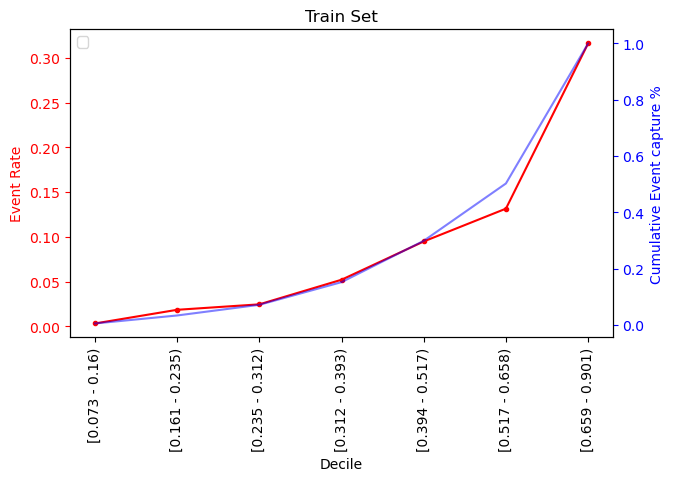

Test Results


,Model,Data,Window,Population,Event,Non Event,Event %,Non Event %,% of Event captured,% of Non Event captured,Cumulative Event,Cumulative Non Event,Cumulative Event capture %,Cumulative Non Event capture %,Mean Probability,ROC AUC,Gini,KS Statistic,Confusion Matrix
0,Logistic Regression,Test,[0.073 - 0.16),123,5.0,118.0,0.040650,0.959350,0.055556,0.131991,5.0,118.0,0.055556,0.131991,0.122523,0.516949,0.033898,0.228814,"[[118, 0], [5, 0]]"
1,Logistic Regression,Test,[0.161 - 0.235),134,12.0,122.0,0.089552,0.910448,0.133333,0.136465,17.0,240.0,0.188889,0.268456,0.199271,0.554645,0.109290,0.147541,"[[122, 0], [12, 0]]"
2,Logistic Regression,Test,[0.235 - 0.312),137,14.0,123.0,0.102190,0.897810,0.155556,0.137584,31.0,363.0,0.344444,0.406040,0.275658,0.682346,0.364692,0.401858,"[[123, 0], [14, 0]]"
3,Logistic Regression,Test,[0.312 - 0.393),130,6.0,124.0,0.046154,0.953846,0.066667,0.138702,37.0,487.0,0.411111,0.544743,0.348564,0.131720,-0.736559,0.048387,"[[124, 0], [6, 0]]"
4,Logistic Regression,Test,[0.394 - 0.517),155,9.0,146.0,0.058065,0.941935,0.100000,0.163311,46.0,633.0,0.511111,0.708054,0.452084,0.710807,0.421613,0.452055,"[[125, 21], [7, 2]]"
5,Logistic Regression,Test,[0.517 - 0.658),158,15.0,143.0,0.094937,0.905063,0.166667,0.159955,61.0,776.0,0.677778,0.868009,0.581143,0.456876,-0.086247,0.075524,"[[0, 143], [0, 15]]"
6,Logistic Regression,Test,[0.659 - 0.901),147,29.0,118.0,0.197279,0.802721,0.322222,0.131991,90.0,894.0,1.000000,1.000000,0.764443,0.685856,0.371712,0.350672,"[[0, 118], [0, 29]]"
7,Logistic Regression,Test,Overall,984,90.0,894.0,0.091463,0.908537,1.000000,1.000000,180.0,1788.0,1.000000,1.000000,0.405608,0.621265,0.242530,0.217673,"[[612, 282], [44, 46]]"


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


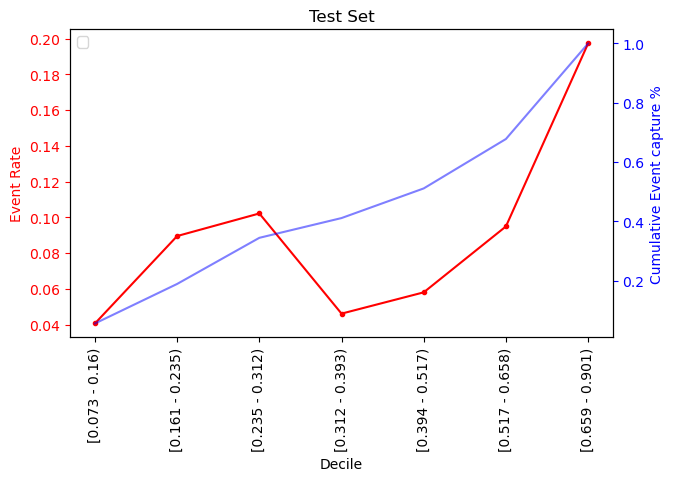

time: 5.56 s (started: 2024-02-22 14:57:47 +05:30)


In [67]:
kgb_grid_cv_decile_logistic_model(train_val2, test2, oversample = False, n_components = None, n_deciles = 7)

### All models

In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import cross_validate

In [ ]:
#Raw
# train_val2 = train_val[[x for x in train_val.columns if '_binned_opt' not in x]]
# test2 = test[[x for x in test.columns if '_binned_opt' not in x]]

# train_val2.fillna(0, inplace=True)
# test2.fillna(0, inplace=True)


#WOE
train_val2 = train_val[StaticVars + [x for x in train_val.columns if '_binned_opt_woe' in x]]
test2 = test[StaticVars + [x for x in test.columns if '_binned_opt_woe' in x]]

In [ ]:
# Define a function to remove special characters
def remove_special_characters(col_name):
    return ''.join(e for e in col_name if e.isalnum() or e.isspace())

# Apply the function to all column names
train_val2.columns = train_val2.columns.map(remove_special_characters)
test2.columns = test2.columns.map(remove_special_characters)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve

from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

def kgb_rand_cv_all_model(train_val, test, oversample = False, n_components = None):
    # Split the data into training and test sets
    X_train = train_val[train_val.columns[~train_val.columns.isin(StaticVars)]]
    X_train.shape
    X_test = test[test.columns[~test.columns.isin(StaticVars)]]
    X_test.shape
    y_train = train_val['event']
    y_train.shape
    y_test = test['event']
    y_test.shape

    lr_param_rand = {
        'penalty': ['l1', 'l2'],
        'C': [0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 25, 50, 75],
        'solver': ['liblinear', 'saga'],
        'max_iter': [2, 5, 7, 10, 15, 20, 25, 50, 60, 90],
    }

    xgb_param_rand = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
            'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.30, 0.4, 0.5, 0.6, 0.7],
            'max_depth': [5,6,7,8,9,10,11,12,13,14],
            'n_estimators': [50,65,80,100,115,130,150],
            'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
            'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}
    
    rf_param_rand = {
        'n_estimators': [50, 100, 200, 400, 800, 1600],
        'max_depth': [None, 5, 10, 20, 40, 80],
        'min_samples_split': [2, 5, 10, 20, 40, 80],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32],
        'max_features': ['auto', 'sqrt'],
        'bootstrap': [True, False],
        'max_samples': [None, 0.7, 0.8, 0.9]
    }

    dt_param_rand = {
        'max_depth': [None, 5, 10, 20, 40, 80],
        'min_samples_split': [2, 5, 10, 20, 40, 80],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32],
        'max_features': ['auto', 'sqrt'],
        'ccp_alpha': [0.0, 0.005, 0.01, 0.02, 0.05]
    }

    feature_names = X_train.columns 

    if oversample == True:
        # Oversample the minority class using SMOTE
        sm = SMOTE(sampling_strategy=0.1, random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        # X_test, y_test = sm.fit_resample(X_test, y_test)
        lr_model = LogisticRegression(random_state=42)
        xgb_model = xgb.XGBClassifier(random_state=42)
        rf_model = RandomForestClassifier(random_state=42)
        dt_model = DecisionTreeClassifier(random_state=42)
    else:
        lr_model = LogisticRegression(random_state=42, class_weight='balanced')
        xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=20)
        rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
        dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

    # Apply PCA for dimensionality reduction
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    lr_rand = RandomizedSearchCV(lr_model, param_distributions=lr_param_rand, cv=5, scoring='f1', n_iter=500)
    lr_rand.fit(X_train, y_train)
    lr_model = lr_rand.best_estimator_
    print("Logistic best parameters", lr_rand.best_estimator_)

    xgb_rand = RandomizedSearchCV(xgb_model, param_distributions=xgb_param_rand, cv=5, scoring='f1', n_iter=100)
    xgb_rand.fit(X_train, y_train)
    xgb_model = xgb_rand.best_estimator_
    print("XGBoost best parameters", xgb_rand.best_estimator_)

    # Randomized Search for Random Forest
    rf_rand = RandomizedSearchCV(rf_model, param_distributions=rf_param_rand, cv=5, scoring='f1', n_iter=100)
    rf_rand.fit(X_train, y_train)
    rf_model = rf_rand.best_estimator_
    print("Random Forest best parameters", rf_rand.best_estimator_)

    # Randomized Search for Decision Tree
    dt_rand = RandomizedSearchCV(dt_model, param_distributions=dt_param_rand, cv=5, scoring='f1', n_iter=100)
    dt_rand.fit(X_train, y_train)
    dt_model = dt_rand.best_estimator_
    print("Decision Tree best parameters", dt_rand.best_estimator_)
    
    train_results = []
    test_results = []
    for name, model in [('Logistic Regression', lr_model), ('XG Boost', xgb_model), ('Random Forest', rf_model), ('Decision Tree', dt_model)]:
        train_pred = model.predict(X_train)
        train_prob = model.predict_proba(X_train)[:, 1]
        train_acc = accuracy_score(y_train, train_pred)
        train_prec = precision_score(y_train, train_pred)
        train_recall = recall_score(y_train, train_pred)
        train_f1 = f1_score(y_train, train_pred)
        train_auc = roc_auc_score(y_train, train_prob)
        train_gini = 2 * train_auc - 1
        train_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_train, train_prob))])
        train_cm = confusion_matrix(y_train, train_pred)
        train_results.append({'Model': name, 'Data': 'Train', 'Accuracy': train_acc, 'Precision': train_prec, 'Recall': train_recall, 'F1 Score': train_f1, 'ROC AUC': train_auc, 'Gini': train_gini, 'KS Statistic': train_ks_stat, 'Confusion Matrix': train_cm})

        test_pred = model.predict(X_test)
        test_prob = model.predict_proba(X_test)[:, 1]
        test_acc = accuracy_score(y_test, test_pred)
        test_prec = precision_score(y_test, test_pred)
        test_recall = recall_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred)
        test_auc = roc_auc_score(y_test, test_prob)
        test_gini = 2 * test_auc - 1
        test_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_test, test_prob))])
        test_cm = confusion_matrix(y_test, test_pred)
        test_results.append({'Model': name, 'Data': 'Test', 'Accuracy': test_acc, 'Precision': test_prec, 'Recall': test_recall, 'F1 Score': test_f1, 'ROC AUC': test_auc, 'Gini': test_gini, 'KS Statistic': test_ks_stat, 'Confusion Matrix': test_cm})

    print("Train Results")
    display(pd.DataFrame(train_results))

    print("Test Results")
    display(pd.DataFrame(test_results))

In [ ]:
kgb_rand_cv_all_model(train_val2, test2, oversample = False, n_components = None)